# AIM0407D2203 Lab 1B Speech Emotion Recognition (SER)
---

1. Ucapan dan emosi adalah dua aspek komunikasi terpenting di antara manusia yang menjadikan Speech Emotion Recognition (SER) sebagai salah satu komponen kunci pada sistem Human-Computer Interaction (HCI). 
2. SER adalah salah satu tugas NLP untuk mengenali aspek emosional dari ucapan manusia terlepas dari isi semantiknya.
3. SER dapat dikembangkan untuk banyak aplikasi, misalnya untuk aplikasi bagi individu dengan Gangguan Spektrum Autisme.

Tujuan utama dari eksperimen ini adalah untuk membuat sistem SER sederhana dan mengeksplorasi algoritma machine learning yang berbeda untuk tugas SER. Secara khusus, kita akan membandingkan pendekatan statistik tradisional dengan metode deep learning yang lebih modern berdasarkan metrik evaluasi untuk mempelajari lebih lanjut tentang struktur data dan kompleksitas tugas SER.

Secara umum, skema yang akan kita lakukan umtuk eksperimen ini akan mengikuti bagan berikut:




# 01 Install & Import Library

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display

import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Import the audio playback widget
import IPython.display as ipd

# 02 Data Acquisition
Kita akan menggunakan RAVDESS (Ryerson Audio-Visual Database of Emotional Speech and Song) dataset untuk melakukan eksperimen ini. Dataset terdiri dari 1440 file dari 24 aktor profesional (12 pria dan 12 wanita) yang dibagi dalam 8 ekspresi emosi: calm, neutral, surprised, happy, angry, sad, fearful, or disgust. Setiap aktor menyuarakan dua pernyataan: 01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door".

Baca selanjutnya tentang RAVDESS: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0196391

In [ ]:
# https://drive.google.com/u/1/uc?id=1sX82joy1Rcw9p-YHZzc0bEfqfzOzckzY&export=download
!gdown 1sX82joy1Rcw9p-YHZzc0bEfqfzOzckzY

Downloading...
From: https://drive.google.com/uc?id=1sX82joy1Rcw9p-YHZzc0bEfqfzOzckzY
To: /content/AIM0407D2203 Lab 1B RAVDESS Speech dataset.zip
100% 223M/223M [00:01<00:00, 119MB/s]


In [ ]:
!unzip -q 'AIM0407D2203 Lab 1B RAVDESS Speech dataset.zip'

In [ ]:
!ls

'AIM0407D2203 Lab 1B RAVDESS Speech dataset.zip'   sample_data
 ravdess_speech_dataset


In [ ]:
RAVD_PATH = 'ravdess_speech_dataset/'   # Path to the directory

dir_list = os.listdir(RAVD_PATH)        # List files in audio directory
dir_list.sort()

dir_list

['Actor_01',
 'Actor_02',
 'Actor_03',
 'Actor_04',
 'Actor_05',
 'Actor_06',
 'Actor_07',
 'Actor_08',
 'Actor_09',
 'Actor_10',
 'Actor_11',
 'Actor_12',
 'Actor_13',
 'Actor_14',
 'Actor_15',
 'Actor_16',
 'Actor_17',
 'Actor_18',
 'Actor_19',
 'Actor_20',
 'Actor_21',
 'Actor_22',
 'Actor_23',
 'Actor_24']

In [ ]:
emotion = []
gender = []
actor = []
file_path = []

for i in dir_list:
  filename = os.listdir(RAVD_PATH + i)    # Iterate over actor folders
  for f in filename:                      # Go through files in Actor folder
    part = f.split('.')[0].split('-')
    emotion.append(int(part[2]))
    actor.append(int(part[6]))
    temp = int(part[6])
    if temp%2 == 0:
      temp = 'female'
    else:
      temp = 'male'
    gender.append(temp)
    file_path.append(RAVD_PATH + i + '/' + f)

In [ ]:
df = pd.DataFrame(emotion)
df = df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
df = pd.concat([pd.DataFrame(gender), df, pd.DataFrame(actor)], axis=1)
df.columns = ['gender','emotion','actor']
df = pd.concat([df, pd.DataFrame(file_path, columns=['path'])], axis=1)
df

,gender,emotion,actor,path
0,male,sad,1,ravdess_speech_dataset/Actor_01/03-01-04-02-01...
1,male,surprise,1,ravdess_speech_dataset/Actor_01/03-01-08-01-01...
2,male,disgust,1,ravdess_speech_dataset/Actor_01/03-01-07-01-02...
3,male,happy,1,ravdess_speech_dataset/Actor_01/03-01-03-02-02...
4,male,fear,1,ravdess_speech_dataset/Actor_01/03-01-06-01-01...
...,...,...,...,...
1435,female,sad,24,ravdess_speech_dataset/Actor_24/03-01-04-01-01...
1436,female,happy,24,ravdess_speech_dataset/Actor_24/03-01-03-01-01...
1437,female,surprise,24,ravdess_speech_dataset/Actor_24/03-01-08-01-01...
1438,female,angry,24,ravdess_speech_dataset/Actor_24/03-01-05-02-02...


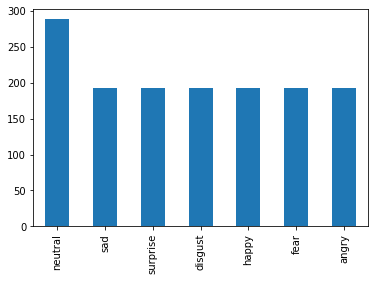

In [ ]:
df.emotion.value_counts().plot(kind='bar')

In [ ]:
df.to_csv('speech_path_df.csv')

# 03 Exploratory Data Analysis (EDA)

Fitur utama dari data audio adalah MFCC (Mel Frequency Cepstral Coefficients) dan Mel Spectrogram

1. MFCC (Mel Frequency Cepstral Coefficients) - MFCC adalah ekstraksi fitur penting saat menggunakan data ucapan. Skala Mel adalah skala yang menghubungkan frekuensi nada yang dirasakan dengan frekuensi nyata yang diukur.
2. Mel Spectogram - A Fast Fourier Transform dihitung pada segmen berjendela yang tumpang tindih dari sinyal. Spektogram adalah cara visual representasi kekuatan sinyal dan juga digunakan untuk menampilkan gelombang frekuensi suara.

## Male Angry

In [ ]:
male_angry = RAVD_PATH + 'Actor_03/03-01-05-01-01-01-03.wav'
data, sr = librosa.load(male_angry)
ipd.Audio(male_angry) 

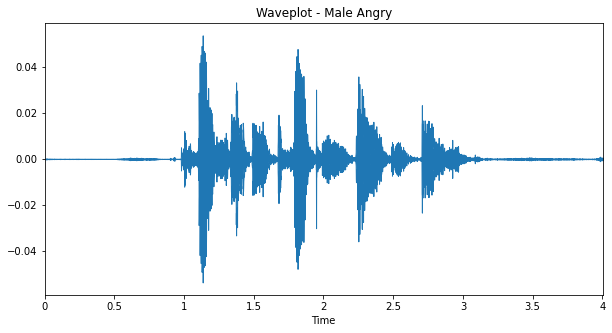

In [ ]:
# Display waveplot
plt.figure(figsize=(10, 5))
librosa.display.waveplot(data, sr=sr)
plt.title('Waveplot - Male Angry')
plt.show()

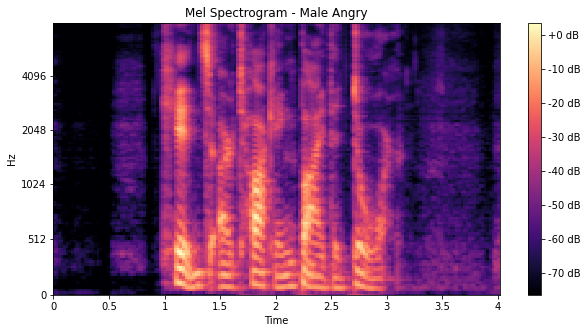

In [ ]:
# Display Log Mel Spectogram
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128, fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)

plt.figure(figsize=(10, 5))
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Male Angry')
plt.colorbar(format='%+2.0f dB')
plt.show()

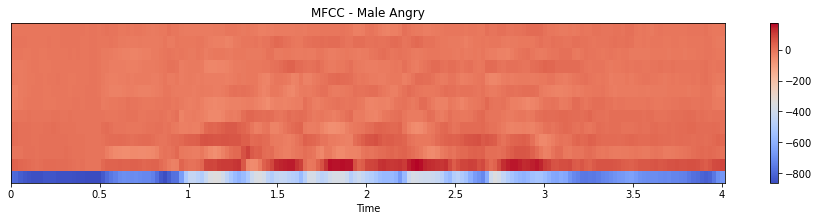

In [ ]:
# Display MFCC
mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=13)

plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.title('MFCC - Male Angry')
plt.colorbar()
plt.show()

## Female Angry

In [ ]:
female_angry = RAVD_PATH + 'Actor_18/03-01-05-01-01-01-18.wav'
data, sr = librosa.load(female_angry)
ipd.Audio(female_angry) 

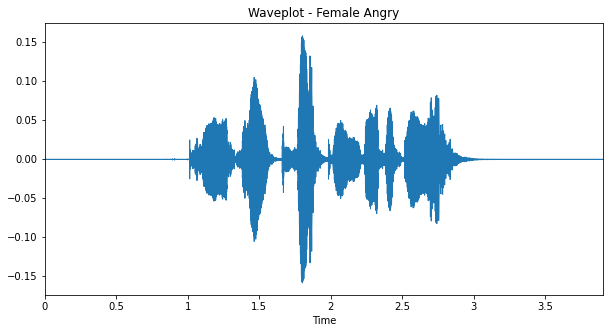

In [ ]:
# Display waveplot
plt.figure(figsize=(10, 5))
librosa.display.waveplot(data, sr=sr)
plt.title('Waveplot - Female Angry')
plt.show()

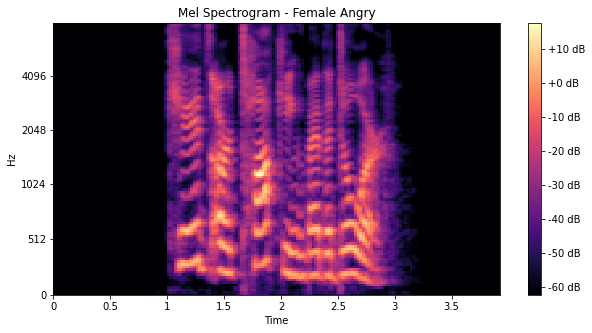

In [ ]:
# Display Log Mel Spectogram
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128, fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)

plt.figure(figsize=(10, 5))
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Female Angry')
plt.colorbar(format='%+2.0f dB')
plt.show()

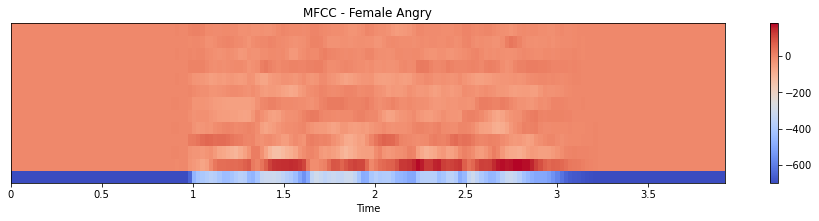

In [ ]:
# Display MFCC
mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=13)

plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.title('MFCC - Female Angry')
plt.colorbar()
plt.show()

## Male Angry vs Female Angry

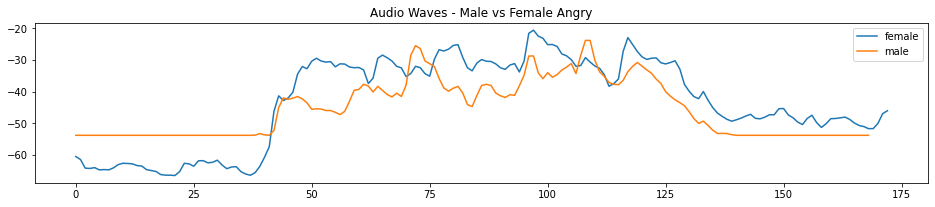

In [ ]:
# Gender - Male; Emotion - Angry
male_angry = RAVD_PATH + 'Actor_03/03-01-05-01-01-01-03.wav'
X, sample_rate = librosa.load(male_angry)  
female = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)

# Gender - Female; Emotion - Angry
female_angry = RAVD_PATH + 'Actor_18/03-01-05-01-01-01-18.wav'
X, sample_rate = librosa.load(female_angry)  
male = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)

# Plot the two audio waves together
plt.figure(figsize=(16,10))
plt.subplot(3,1,1)
plt.plot(female, label='female')
plt.plot(male, label='male')
plt.title('Audio Waves - Male vs Female Angry')
plt.legend()
plt.show()

# 04 Data Augmentation
- Augmentasi data adalah proses di mana kita membuat sampel data terpolimerisasi baru dengan menambahkan sedikit gangguan pada set pelatihan awal.
- Tujuannya adalah untuk membuat model kita invarian terhadap gangguan tersebut dan meningkatkan kemampuannya untuk menggeneralisasi. Agar ini berfungsi, menambahkan gangguan harus mempertahankan label yang sama dengan sampel pelatihan asli.

In [ ]:
# Ambil satu sample data yang diambil dari dataset
sample_data = np.array(df['path'])[471]
data, sample_rate = librosa.load(sample_data)

## Normal Audio

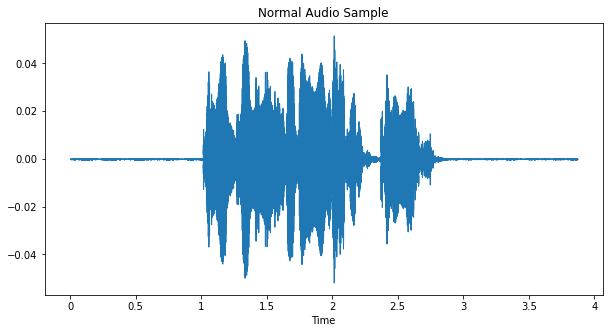

In [ ]:
plt.figure(figsize=(10, 5))
librosa.display.waveshow(y=data, sr=sample_rate)
plt.title('Normal Audio Sample')

ipd.Audio(sample_data)

## Audio with Noise

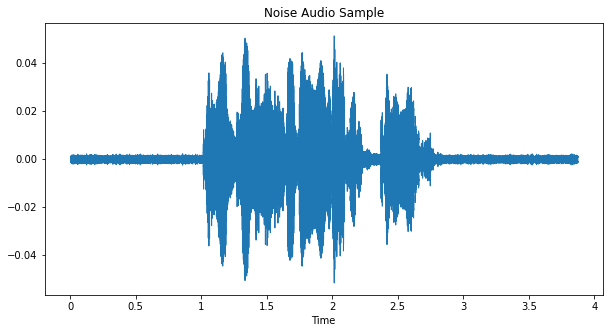

In [ ]:
def get_noise(data):
  noise_amp = 0.035*np.random.uniform()*np.amax(data)
  data = data + noise_amp*np.random.normal(size=data.shape[0])
  return data

x = get_noise(data)
plt.figure(figsize=(10,5))
librosa.display.waveshow(y=x, sr=sample_rate)
plt.title('Noise Audio Sample')

ipd.Audio(x, rate=sample_rate)

## Audio with Pitch

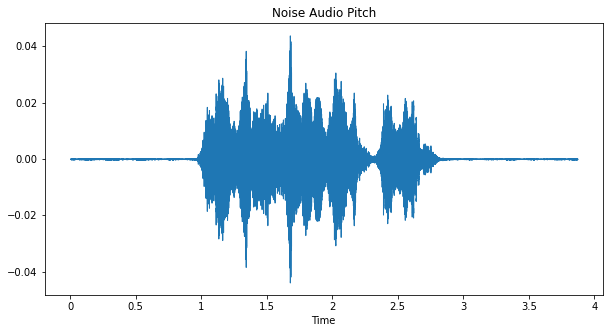

In [ ]:
def get_pitch(data, sampling_rate, pitch_factor=0.7):
  return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

x = get_pitch(data, sample_rate)
plt.figure(figsize=(10,5))
librosa.display.waveshow(y=x, sr=sample_rate)
plt.title('Noise Audio Pitch')

ipd.Audio(x, rate=sample_rate)

## Shifted Audio

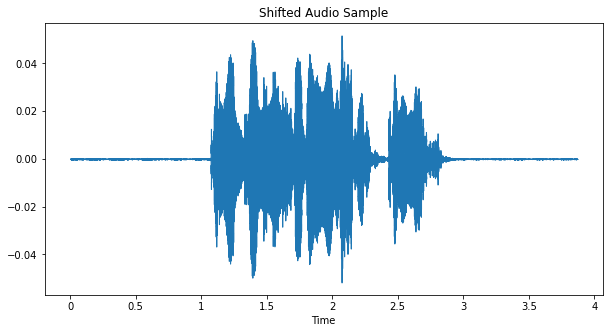

In [ ]:
def get_shift(data):
  shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
  return np.roll(data, shift_range)

x = get_shift(data)
plt.figure(figsize=(10,5))
librosa.display.waveshow(y=x, sr=sample_rate)
plt.title('Shifted Audio Sample')

ipd.Audio(x, rate=sample_rate)

## Stretched Audio

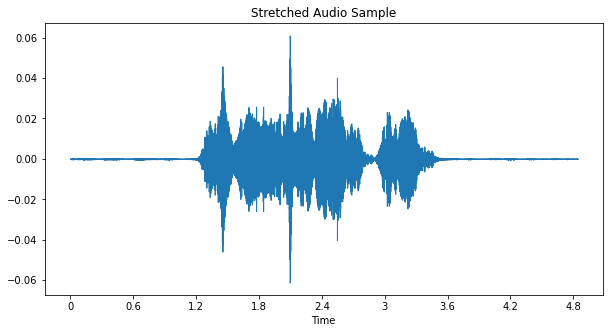

In [ ]:
def get_stretch(data, rate=0.8):
  return librosa.effects.time_stretch(data, rate)

x = get_stretch(data)
plt.figure(figsize=(10,5))
librosa.display.waveshow(y=x, sr=sample_rate)
plt.title('Stretched Audio Sample')

ipd.Audio(x, rate=sample_rate)

## Increase Audio Speed with Pitch

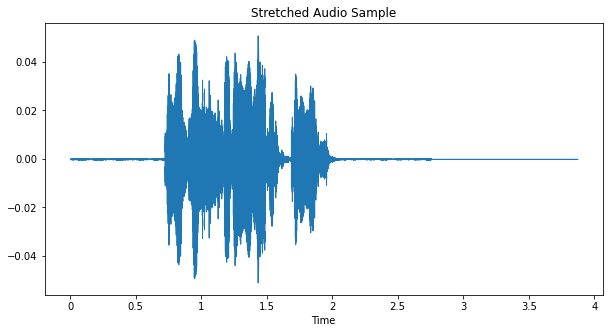

In [ ]:
def get_speedpitch(data):
  length_change = np.random.uniform(low=0.8, high=1)
  speed_fac = 1.4  / length_change 
  tmp = np.interp(np.arange(0, len(data),speed_fac), np.arange(0,len(data)), data)
  minlen = min(data.shape[0], tmp.shape[0])
  data *= 0
  data[0:minlen] = tmp[0:minlen]
  return data

x = get_speedpitch(data)
plt.figure(figsize=(10,5))
librosa.display.waveshow(y=x, sr=sample_rate)
plt.title('Stretched Audio Sample')

ipd.Audio(x, rate=sample_rate)

# 05 Feature Extraction

Representasi domain suara sangat kompleks dan dalam bentuk aslinya, tidak memberikan wawasan yang sangat baik tentang karakteristik utama sinyal suara. Karena karakteristik sinyal suara ini, kami memetakan representasi domain waktu ini menjadi fitur yang lebih jelas. Teknik yang paling mudah melibatkan penentuan energi rata-rata sinyal. Metrik ini, bersama dengan energi total dalam sinyal, menunjukkan "volume" speaker. Durasi juga menawarkan wawasan tentang emosi, seperti halnya statistik seperti maksimum, minimum, jangkauan, rata-rata, dan standar deviasi dari sinyal dan spektrum. Ini mungkin menunjukkan fluktuasi dalam volume atau nada yang dapat berguna dalam menentukan emosi. Untuk sinyal dan spektrum, kami juga memperoleh kemiringan, ukuran penyimpangan simetri horizontal dalam sinyal, dan kurtosis, ukuran tinggi dan ketajaman puncak pusat, relatif terhadap kurva lonceng standar.

In [ ]:
def get_audio_features(path):
  data, sample_rate = librosa.load(path, res_type='kaiser_fast', sr=20000*2, duration=2.5, offset=0.5)
  sampe_rate = np.array(sample_rate)
                        
  y_harmonic, y_percussive = librosa.effects.hpss(data)
  pitches, magnitudes = librosa.core.pitch.piptrack(y=data, sr=sample_rate)

  mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=13), axis=1)
  pitches = np.trim_zeros(np.mean(pitches, axis=1))[:20]
  magnitudes = np.trim_zeros(np.mean(magnitudes, axis=1))[:20]
  C = np.mean(librosa.feature.chroma_cqt(y=y_harmonic, sr=20000), axis=1)

  return [mfcc, pitches, magnitudes, C]
  
def get_features_dataframe(dataframe):
  features  = pd.DataFrame(columns=['mfcc','pitches','magnitudes','C'])
  for index, audio_path in enumerate(df['path']):
    features.loc[index] = get_audio_features(audio_path)
  
  mfcc = features.mfcc.apply(pd.Series)
  pit = features.pitches.apply(pd.Series)
  mag = features.magnitudes.apply(pd.Series)
  C = features.C.apply(pd.Series)
  
  features = pd.concat([mfcc, pit, mag,C], axis=1, ignore_index=True)

  return features

In [ ]:
%%time
features_df = pd.concat([df, get_features_dataframe(df)], axis=1)

features_df

CPU times: user 14min 9s, sys: 5min 35s, total: 19min 44s
Wall time: 13min 36s


,gender,emotion,actor,path,0,1,2,3,4,5,...,55,56,57,58,59,60,61,62,63,64
0,male,sad,1,ravdess_speech_dataset/Actor_01/03-01-04-02-01...,-577.796448,95.487724,-5.652750,15.595651,6.019970,12.708937,...,0.386398,0.374262,0.358748,0.344654,0.364893,0.331052,0.235445,0.313443,0.432526,0.348139
1,male,surprise,1,ravdess_speech_dataset/Actor_01/03-01-08-01-01...,-656.023438,80.748871,0.018554,9.760427,8.623574,11.611739,...,0.573284,0.460035,0.395406,0.418711,0.405111,0.441564,0.413798,0.425262,0.628341,0.582536
2,male,disgust,1,ravdess_speech_dataset/Actor_01/03-01-07-01-02...,-612.070251,98.297981,5.997546,21.543692,7.777071,12.098349,...,0.386045,0.290912,0.242351,0.329639,0.387403,0.313059,0.363656,0.288815,0.475317,0.476316
3,male,happy,1,ravdess_speech_dataset/Actor_01/03-01-03-02-02...,-459.209381,99.316086,-13.611694,13.294849,-3.518813,10.621624,...,0.443117,0.488870,0.486969,0.549006,0.386339,0.369290,0.299192,0.227843,0.226980,0.242416
4,male,fear,1,ravdess_speech_dataset/Actor_01/03-01-06-01-01...,-540.092407,92.848625,0.766511,16.985044,9.189572,16.276180,...,0.468955,0.440555,0.494104,0.372909,0.210755,0.230959,0.242345,0.282957,0.401426,0.406889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,female,sad,24,ravdess_speech_dataset/Actor_24/03-01-04-01-01...,-662.621826,87.842575,-1.410087,19.761375,-6.067214,6.031284,...,0.255020,0.256458,0.153992,0.120232,0.167489,0.477212,0.663760,0.464935,0.241055,0.124974
1436,female,happy,24,ravdess_speech_dataset/Actor_24/03-01-03-01-01...,-583.922974,92.641624,-25.300781,4.181529,-5.207701,-0.036810,...,0.297653,0.320897,0.279037,0.271929,0.313679,0.338541,0.410031,0.414906,0.478000,0.347316
1437,female,surprise,24,ravdess_speech_dataset/Actor_24/03-01-08-01-01...,-525.189636,63.288933,-19.888201,0.569851,-15.329300,-4.352988,...,0.362067,0.350461,0.309630,0.431737,0.373983,0.479573,0.565228,0.530384,0.572566,0.468715
1438,female,angry,24,ravdess_speech_dataset/Actor_24/03-01-05-02-02...,-432.915741,67.417419,-23.015928,8.930740,-13.862512,-6.687475,...,0.235985,0.161270,0.190193,0.265158,0.238287,0.233984,0.275922,0.390022,0.705978,0.588406


In [ ]:
# Save features dataframe
features_df.to_csv('speech_feature_df.csv', index=False)

# 06 Prepping Data for Modeling

In [ ]:
# Pisahkan kolom fitur dan target
X = features_df.iloc[:, 4:].values
y = features_df['emotion'].values

## One-hot Encoding

In [ ]:
# Encode categorical features as a one-hot numeric array.
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

from sklearn.preprocessing import OneHotEncoder

label_encoder = OneHotEncoder()
y = label_encoder.fit_transform(np.array(y).reshape(-1,1)).toarray()

In [ ]:
y

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [ ]:
label_encoder.categories_

[array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
       dtype=object)]

## Train & Test Data Splitting

In [ ]:
# Split arrays or matrices into random train and test subsets.
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=features_df[['emotion','gender','actor']], random_state=0)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1152, 65), (288, 65), (1152, 7), (288, 7))

## Reshape Data to 3D Tensor

In [ ]:
X_train_tensor = X_train.reshape(X_train.shape[0] , X_train.shape[1] , 1)
X_test_tensor = X_test.reshape(X_test.shape[0] , X_test.shape[1] , 1)

X_train_tensor.shape, X_test_tensor.shape

((1152, 65, 1), (288, 65, 1))

# 07 Modelling
Kita akan membandingkan pendekatan statistik tradisional (baseline) dengan metode deep learning (CNN) untuk tugas SER.

## Baseline Model (Machine Learning)

### Decision Tree

In [ ]:
# A decision tree classifier.
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

from sklearn.tree import DecisionTreeClassifier

clf_1 = DecisionTreeClassifier()              

clf_1.fit(X_train, y_train)
clf_1.predict(X_test)

print("Training set score: {:.3f}".format(clf_1.score(X_train, y_train)))
print("Test set score: {:.3f}".format(clf_1.score(X_test, y_test)))

Training set score: 1.000
Test set score: 0.420


### k Nearest Neighbor



In [ ]:
# Classifier implementing the k-nearest neighbors vote.
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

from sklearn.neighbors import KNeighborsClassifier

clf_2 = KNeighborsClassifier(n_neighbors=4)
            
clf_2.fit(X_train, y_train)
clf_2.predict(X_test)

print("Training set score: {:.3f}".format(clf_2.score(X_train, y_train)))
print("Test set score: {:.3f}".format(clf_2.score(X_test, y_test)))

Training set score: 0.326
Test set score: 0.191


## Deep Learning Model

### Define Model (Convolutional Neural Network)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout, Dense 

In [ ]:
model = Sequential()
model.add(Conv1D(filters=256, kernel_size=10, activation='relu', input_shape=(X_train_tensor.shape[1], X_train_tensor.shape[2])))
model.add(Conv1D(filters=128, kernel_size=10, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=10, activation='relu'))
model.add(MaxPooling1D(pool_size=8))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(len(label_encoder.get_feature_names_out()), activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 56, 256)           2816      
                                                                 
 conv1d_1 (Conv1D)           (None, 47, 128)           327808    
                                                                 
 conv1d_2 (Conv1D)           (None, 38, 64)            81984     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 4, 64)            0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 4, 64)             0         
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                        

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Training

In [ ]:
%%time

EPOCH = 25
BATCH_SIZE = 32

model_history = model.fit(X_train_tensor, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, validation_data=(X_test_tensor, y_test))

Epoch 1/25
36/36 [==============================] - 12s 12ms/step - loss: 2.5572 - accuracy: 0.1415 - val_loss: 1.9657 - val_accuracy: 0.1667
Epoch 2/25
36/36 [==============================] - 0s 5ms/step - loss: 1.9531 - accuracy: 0.1736 - val_loss: 1.9539 - val_accuracy: 0.1736
Epoch 3/25
36/36 [==============================] - 0s 5ms/step - loss: 1.9420 - accuracy: 0.1918 - val_loss: 1.9425 - val_accuracy: 0.1667
Epoch 4/25
36/36 [==============================] - 0s 5ms/step - loss: 1.9311 - accuracy: 0.2101 - val_loss: 1.9544 - val_accuracy: 0.1667
Epoch 5/25
36/36 [==============================] - 0s 5ms/step - loss: 1.9379 - accuracy: 0.2075 - val_loss: 1.9414 - val_accuracy: 0.1667
Epoch 6/25
36/36 [==============================] - 0s 5ms/step - loss: 1.9280 - accuracy: 0.2075 - val_loss: 1.9498 - val_accuracy: 0.1667
Epoch 7/25
36/36 [==============================] - 0s 5ms/step - loss: 1.9137 - accuracy: 0.2083 - val_loss: 1.9154 - val_accuracy: 0.1667
Epoch 8/25
36/36 [

In [ ]:
# Buat fungsi untuk plotting hasil training
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

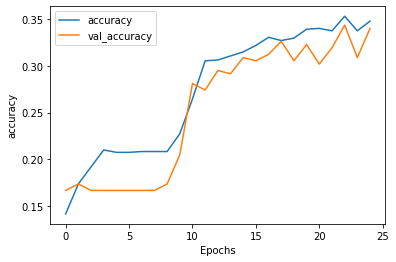

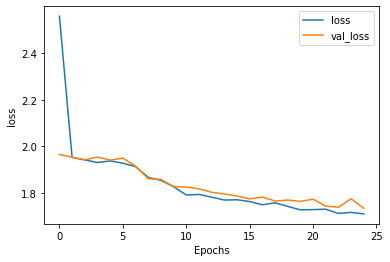

In [ ]:
plot_graphs(model_history, 'accuracy')
plot_graphs(model_history, 'loss')

In [ ]:
print('\nEpoch No.  Train Accuracy  Train Loss      Val Accuracy    Val Loss')
for i in range(EPOCH):
  print('{:8d} {:10f} \t {:10f} \t {:10f} \t {:10f}'.format(i + 1, model_history.history['accuracy'][i], model_history.history['loss'][i], model_history.history['val_accuracy'][i], model_history.history['val_loss'][i]))


Epoch No.  Train Accuracy  Train Loss      Val Accuracy    Val Loss
       1   0.141493 	   2.557151 	   0.166667 	   1.965665
       2   0.173611 	   1.953060 	   0.173611 	   1.953923
       3   0.191840 	   1.942037 	   0.166667 	   1.942535
       4   0.210069 	   1.931092 	   0.166667 	   1.954421
       5   0.207465 	   1.937886 	   0.166667 	   1.941401
       6   0.207465 	   1.928042 	   0.166667 	   1.949760
       7   0.208333 	   1.913692 	   0.166667 	   1.915403
       8   0.208333 	   1.867561 	   0.166667 	   1.861435
       9   0.208333 	   1.854698 	   0.173611 	   1.858637
      10   0.227431 	   1.827406 	   0.204861 	   1.828174
      11   0.264757 	   1.792008 	   0.281250 	   1.826099
      12   0.305556 	   1.794391 	   0.274306 	   1.818599
      13   0.306424 	   1.782928 	   0.295139 	   1.803641
      14   0.310764 	   1.770378 	   0.291667 	   1.796595
      15   0.315104 	   1.771659 	   0.309028 	   1.787333
      16   0.322049 	   1.763833 	   0.305556 

### Evaluate

In [ ]:
# Lakukan prediksi pada data uji
y_pred = np.argmax(model.predict(X_test_tensor), axis=1)
y_true = np.argmax(y_test, axis=1)

loss, accuracy = model.evaluate(X_test_tensor, y_test)

9/9 [==============================] - 0s 3ms/step - loss: 1.7348 - accuracy: 0.3403


In [ ]:
from sklearn.metrics import classification_report

# Tampilkan laporan klasifikasi yang dilakukan model pada data uji
print(classification_report(y_pred, y_true, target_names=label_encoder.get_feature_names_out([''])))

              precision    recall  f1-score   support

      _angry       0.56      0.32      0.41        74
    _disgust       0.21      0.19      0.20        43
       _fear       0.00      0.00      0.00         0
      _happy       0.00      0.00      0.00         0
    _neutral       0.90      0.45      0.60        96
        _sad       0.00      0.00      0.00         0
   _surprise       0.56      0.31      0.40        75

    accuracy                           0.34       288
   macro avg       0.32      0.18      0.23       288
weighted avg       0.62      0.34      0.44       288



# 08 Prediction

In [ ]:
sample_data

'ravdess_speech_dataset/Actor_08/03-01-07-02-02-02-08.wav'

In [ ]:
demo_audio_path = sample_data

ipd.Audio(sample_data)

In [ ]:
demo_mfcc, demo_pitch, demo_mag, demo_chrom = get_audio_features(demo_audio_path)

mfcc = pd.Series(demo_mfcc)
pit = pd.Series(demo_pitch)
mag = pd.Series(demo_mag)
C = pd.Series(demo_chrom)

demo_audio_features = pd.concat([mfcc,pit,mag,C], ignore_index=True)

In [ ]:
demo_audio_features

0    -582.023987
1      82.585312
2      10.408059
3      20.984415
4       3.175798
         ...    
60      0.396159
61      0.427722
62      0.395070
63      0.471928
64      0.230382
Length: 65, dtype: float32

In [ ]:
# Reshape to 3D tensor
demo_audio_features = np.expand_dims(demo_audio_features, axis=0)
demo_audio_features = np.expand_dims(demo_audio_features, axis=2)

demo_audio_features.shape

(1, 65, 1)

In [ ]:
demo_preds = model.predict(demo_audio_features)
demo_preds

array([[0.28905144, 0.56687796, 0.45430917, 0.47044414, 0.68343353,
        0.6160466 , 0.41279972]], dtype=float32)

In [ ]:
emotions = ['anger','disgust','fear','happy','neutral','sad','surprise']

In [ ]:
index = demo_preds.argmax(axis=1).item()
index

4

In [ ]:
emotions[index]

'neutral'

# 09 Simple Deployment Using Gradio

In [ ]:
'''
Gradio is the fastest way to demo your machine learning model with a friendly web interface so that anyone can use it, anywhere!
https://gradio.app/
'''

!pip -q install gradio

     |████████████████████████████████| 6.1 MB 32.3 MB/s 
     |████████████████████████████████| 57 kB 5.7 MB/s 
     |████████████████████████████████| 270 kB 56.4 MB/s 
     |████████████████████████████████| 55 kB 4.2 MB/s 
     |████████████████████████████████| 112 kB 69.8 MB/s 
     |████████████████████████████████| 84 kB 3.9 MB/s 
     |████████████████████████████████| 2.3 MB 61.5 MB/s 
     |████████████████████████████████| 212 kB 70.2 MB/s 
     |████████████████████████████████| 54 kB 3.7 MB/s 
     |████████████████████████████████| 84 kB 3.7 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████████████| 80 kB 9.8 MB/s 
     |████████████████████████████████| 68 kB 7.5 MB/s 
     |████████████████████████████████| 43 kB 2.4 MB/s 
     |████████████████████████████████| 856 kB 63.1 MB/s 
     |████████████████████████████████| 594 kB 65.5 MB/s 
     |████████████████████████████████| 4.1 MB 67.6 MB/s 


In [ ]:
import gradio as gr

def ser(file):
  audio_mfcc, audio_pitch, audio_mag, audio_chrom = get_audio_features(file)

  mfcc = pd.Series(audio_mfcc)
  pit = pd.Series(audio_pitch)
  mag = pd.Series(audio_mag)
  C = pd.Series(audio_chrom)

  audio_features = pd.concat([mfcc,pit,mag,C], ignore_index=True)

  audio_features = np.expand_dims(audio_features, axis=0)
  audio_features = np.expand_dims(audio_features, axis=2)

  model_predict = model.predict(audio_features)
  model_output = model_predict.argmax(axis=1).item()

  emotions = ['anger','disgust','fear','happy','neutral','sad','surprise']
  
  return emotions[model_output]

iface = gr.Interface(fn=ser, 
                     inputs=gr.inputs.Audio(source="microphone", type="filepath"), 
                     outputs="text",
                     live=True)

iface.launch()

Hint: Set streaming=True for Audio component to use live streaming.
Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Your interface requires microphone or webcam permissions - this may cause issues in Colab. Use the External URL in case of issues.
Running on public URL: https://11782.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://huggingface.co/spaces


(<gradio.routes.App at 0x7f9806101990>,
 'http://127.0.0.1:7860/',
 'https://11782.gradio.app')

# 10 Student Activity